In [1]:
from google.colab import drive
drive.mount("/content/drive")

%cd /content/drive/MyDrive/Environmental-sounds-UNIPD-2022

Mounted at /content/drive
/content/drive/MyDrive/Environmental-sounds-UNIPD-2022


In [2]:
import os
import sys
import torch
import librosa
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from librosa import display
from scipy.io import wavfile
from tensorflow import keras
import IPython.display as ipd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import evaluation
import CNN_support as cnns
from gng import GrowingNeuralGas

%load_ext autoreload
%autoreload 2

In [3]:
#reading the csv file
data = pd.read_csv('./data/meta/esc50.csv')
data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [6]:
# Identify and select the TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.TPUStrategy(tpu)
except:
  print("TPU not found")

## 1. RNN with 60x431 input

In [4]:
X1 = pd.read_parquet(".//data/X_RNN_60x431_8times.parquet")
y1 = pd.read_parquet(".//data/y_RNN_60x431_8times.parquet")

X1 = X1.values.reshape(len(X1), 60, 431)
y1 = y1.values

In [5]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, train_size = .75,
                                                        random_state = 42, shuffle = True)
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X_train1, y_train1, train_size = .8,
                                                          random_state = 42, shuffle = True)

# one hot encoding of categories
y_train1 = tf.keras.utils.to_categorical(y_train1)
y_valid1 = tf.keras.utils.to_categorical(y_valid1)
y_test1 = tf.keras.utils.to_categorical(y_test1)

print("Training examples: {}".format(y_train1.shape[0]))
print("Validation examples: {}".format(y_valid1.shape[0]))
print("Test examples: {}".format(y_test1.shape[0]))
print()
print("Input shape: {}".format(X_train1[0].shape))

Training examples: 9600
Validation examples: 2400
Test examples: 4000

Input shape: (60, 431)


In [7]:
BATCH_SIZE1 = 100

In [8]:
with tpu_strategy.scope():
  null_model = keras.models.Sequential([keras.Input(shape = (60, 431)),
                                        keras.layers.Bidirectional(
                                              keras.layers.LSTM(int(431*3),
                                                                return_sequences = True)),
                                        keras.layers.Flatten(),
                                        keras.layers.Dense(400, activation = "relu"),
                                        keras.layers.Dropout(0.2),
                                        keras.layers.Dense(200, activation = "relu"),
                                        keras.layers.Dropout(0.2),
                                        keras.layers.Dense(100, activation = "relu"),
                                        keras.layers.Dropout(0.2),
                                        keras.layers.Dense(50, activation = "softmax")])
  null_model.compile(loss = "categorical_crossentropy",
                     optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                     metrics=["accuracy"])

print(null_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 60, 2586)         17843400  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 155160)            0         
                                                                 
 dense (Dense)               (None, 400)               62064400  
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               80200     
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                        

In [9]:
nullHST = null_model.fit(X_train1, y_train1,
                         epochs = 100,
                         batch_size = BATCH_SIZE1,
                         validation_data = (X_valid1, y_valid1),
                         verbose = 0,
                         callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                                    patience = 10)])


125/125 - 6s - loss: 2.2000 - accuracy: 0.5133 - 6s/epoch - 48ms/step
Accuracy on test: 51.33%
Memory used: 204.7 Mb


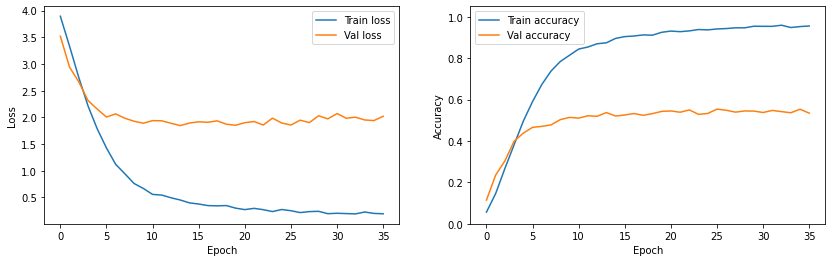

In [10]:
# Plot loss
fig1, ax1 = plt.subplots(1, 2, figsize = (14, 4))
ax1[0].plot(nullHST.history['loss'], label='Train loss')
ax1[0].plot(nullHST.history['val_loss'], label='Val loss')
ax1[0].legend()
ax1[0].set_xlabel('Epoch')
ax1[0].set_ylabel('Loss')

# Plot accuracy
ax1[1].plot(nullHST.history['accuracy'], label='Train accuracy')
ax1[1].plot(nullHST.history['val_accuracy'], label='Val accuracy')
ax1[1].legend()
ax1[1].set_xlabel('Epoch')
ax1[1].set_ylabel('Accuracy')
ax1[1].set_ylim(0, 1.05)

print()
scores_NULL1 = null_model.evaluate(X_test1,#.reshape(len(X_test), 1, X_test.shape[1]),
                                  y_test1, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores_NULL1[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = null_model,
                                                     batch_size = BATCH_SIZE1)/1e6))

plt.show()

## 2. RNN with 1x431 input

In [38]:
X2 = pd.read_parquet(".//data/X_RNN_1x431.parquet")
y2 = pd.read_parquet(".//data/y_RNN_1x431.parquet")

X2 = X2.values.reshape(len(X2), 1, 431)
y2 = y2.values


from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size = .75,
                                                        random_state = 42, shuffle = True)
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X_train2, y_train2, train_size = .8,
                                                          random_state = 42, shuffle = True)

# one hot encoding of categories
y_train2 = tf.keras.utils.to_categorical(y_train2)
y_valid2 = tf.keras.utils.to_categorical(y_valid2)
y_test2 = tf.keras.utils.to_categorical(y_test2)

print("Training examples: {}".format(y_train2.shape[0]))
print("Validation examples: {}".format(y_valid2.shape[0]))
print("Test examples: {}".format(y_test2.shape[0]))
print()
print("Input shape: {}".format(X_train2[0].shape))

Training examples: 6000
Validation examples: 1500
Test examples: 2500

Input shape: (1, 431)


In [23]:
BATCH_SIZE1 = 100

In [39]:
with tpu_strategy.scope():
  model2 = keras.models.Sequential([keras.Input(shape = (1, 431)),
                                    keras.layers.Bidirectional(
                                              keras.layers.LSTM(int(431*3),
                                                                return_sequences = True)),
                                    keras.layers.Flatten(),
                                    keras.layers.Dense(400, activation = "relu"),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(200, activation = "relu"),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(100, activation = "relu"),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(50, activation = "softmax")])
  model2.compile(loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                 metrics=["accuracy"])

print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 1, 2586)          17843400  
 nal)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 2586)              0         
                                                                 
 dense_12 (Dense)            (None, 400)               1034800   
                                                                 
 dropout_9 (Dropout)         (None, 400)               0         
                                                                 
 dense_13 (Dense)            (None, 200)               80200     
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                      

In [40]:
HST2 = model2.fit(X_train2, y_train2,
                  epochs = 100,
                  batch_size = BATCH_SIZE1,
                  validation_data = (X_valid2, y_valid2),
                  verbose = 0,
                  callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                             patience = 10)])


79/79 - 2s - loss: 3.8597 - accuracy: 0.0592 - 2s/epoch - 27ms/step
Accuracy on test: 5.92%
Memory used: 21.6 Mb


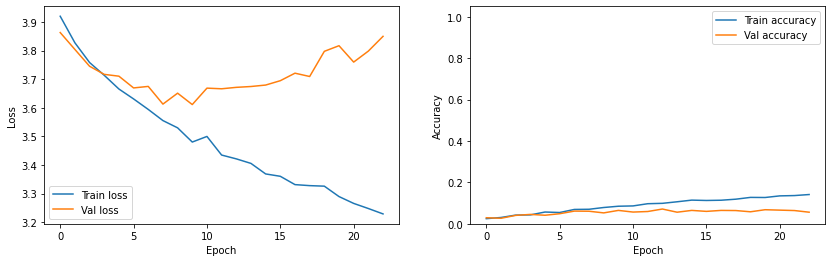

In [41]:
# Plot loss
fig1, ax1 = plt.subplots(1, 2, figsize = (14, 4))
ax1[0].plot(HST2.history['loss'], label='Train loss')
ax1[0].plot(HST2.history['val_loss'], label='Val loss')
ax1[0].legend()
ax1[0].set_xlabel('Epoch')
ax1[0].set_ylabel('Loss')

# Plot accuracy
ax1[1].plot(HST2.history['accuracy'], label='Train accuracy')
ax1[1].plot(HST2.history['val_accuracy'], label='Val accuracy')
ax1[1].legend()
ax1[1].set_xlabel('Epoch')
ax1[1].set_ylabel('Accuracy')
ax1[1].set_ylim(0, 1.05)

print()
scores2 = model2.evaluate(X_test2, y_test2, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores2[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model2,
                                                     batch_size = BATCH_SIZE1)/1e6))

plt.show()

## 3. RNN with 1x60 input

In [22]:
X3 = pd.read_parquet(".//data/X_RNN_60x431_8times.parquet").values
y3 = pd.read_parquet(".//data/y_RNN_60x431_8times.parquet").values
X3 = X3.reshape(len(X3), 60, 431).mean(axis = 2).reshape(len(X3), 1, 60)

from sklearn.model_selection import train_test_split

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, train_size = .75,
                                                        random_state = 42, shuffle = True)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_train3, y_train3, train_size = .8,
                                                          random_state = 42, shuffle = True)

# one hot encoding of categories
y_train3 = tf.keras.utils.to_categorical(y_train3)
y_valid3 = tf.keras.utils.to_categorical(y_valid3)
y_test3 = tf.keras.utils.to_categorical(y_test3)

print("Training examples: {}".format(y_train3.shape[0]))
print("Validation examples: {}".format(y_valid3.shape[0]))
print("Test examples: {}".format(y_test3.shape[0]))
print()
print("Input shape: {}".format(X_train3[0].shape))

Training examples: 9600
Validation examples: 2400
Test examples: 4000

Input shape: (1, 60)


In [35]:
with tpu_strategy.scope():
  model3 = keras.models.Sequential([keras.Input(shape = (1, 60)),
                                    #keras.layers.LSTM(200,
                                    #                  return_sequences = True),
                                    keras.layers.Bidirectional(keras.layers.LSTM(1000,
                                                                       return_sequences = True)),
                                    keras.layers.Flatten(),
                                    keras.layers.Dense(500, activation = "relu"),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(200, activation = "relu"),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(100, activation = "relu"),
                                    keras.layers.Dropout(0.2),
                                    keras.layers.Dense(50, activation = "softmax")])
  model3.compile(loss = "categorical_crossentropy",
                 optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                 metrics=["accuracy"])

print(model3.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 1, 2000)          8488000   
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 2000)              0         
                                                                 
 dense_16 (Dense)            (None, 500)               1000500   
                                                                 
 dropout_11 (Dropout)        (None, 500)               0         
                                                                 
 dense_17 (Dense)            (None, 200)               100200    
                                                                 
 dropout_12 (Dropout)        (None, 200)               0         
                                                      

In [32]:
BATCH_SIZE3 = 100

In [36]:
HST3 = model3.fit(X_train3, y_train3,
                  epochs = 200,
                  batch_size = BATCH_SIZE3,
                  validation_data = (X_valid3, y_valid3),
                  verbose = 0,
                  callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                             patience = 10)])


125/125 - 2s - loss: 1.4727 - accuracy: 0.7098 - 2s/epoch - 14ms/step
Accuracy on test: 70.98%
Memory used: 11.9 Mb


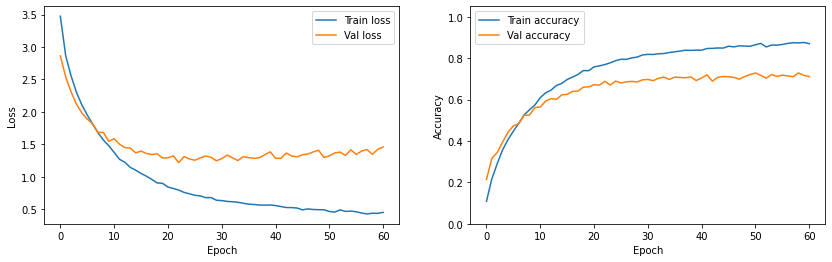

In [37]:
# Plot loss
fig1, ax1 = plt.subplots(1, 2, figsize = (14, 4))
ax1[0].plot(HST3.history['loss'], label='Train loss')
ax1[0].plot(HST3.history['val_loss'], label='Val loss')
ax1[0].legend()
ax1[0].set_xlabel('Epoch')
ax1[0].set_ylabel('Loss')

# Plot accuracy
ax1[1].plot(HST3.history['accuracy'], label='Train accuracy')
ax1[1].plot(HST3.history['val_accuracy'], label='Val accuracy')
ax1[1].legend()
ax1[1].set_xlabel('Epoch')
ax1[1].set_ylabel('Accuracy')
ax1[1].set_ylim(0, 1.05)

print()
scores3 = model3.evaluate(X_test3, y_test3, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores3[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model3,
                                                     batch_size = BATCH_SIZE3)/1e6))

plt.show()

In [39]:
# HUGE MODEL ON SAME DATA
with tpu_strategy.scope():
    # LSTM - complete with model definition, summary, fit and plots.
    model_bidirectional = keras.models.Sequential()
    model_bidirectional.add(keras.Input(shape = (1, 60)))
    model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(1024,
                                                                        return_sequences = True)))
    model_bidirectional.add(keras.layers.Dropout(0.2))
    model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(2048,
                                                                        return_sequences = True)))
    model_bidirectional.add(keras.layers.Dropout(0.2))
    model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(3036,
                                                                        return_sequences = False)))
    model_bidirectional.add(keras.layers.Dropout(0.2))  
    model_bidirectional.add(keras.layers.Flatten())         
    model_bidirectional.add(keras.layers.Dense(50, activation="softmax"))

    model_bidirectional.compile(loss = "categorical_crossentropy",
                                optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                                metrics=["accuracy"])
    
print(model_bidirectional.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 1, 2048)          8888320   
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 1, 2048)           0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 1, 4096)          67125248  
 nal)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 1, 4096)           0         
                                                                 
 bidirectional_9 (Bidirectio  (None, 6072)             173246304 
 nal)                                                            
                                                      

In [40]:
HST3huge = model_bidirectional.fit(X_train3, y_train3,
                                   epochs = 200,
                                   batch_size = BATCH_SIZE3,
                                   validation_data = (X_valid3, y_valid3),
                                   verbose = 0,
                                   callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                                              patience = 10)])


125/125 - 3s - loss: 1.3183 - accuracy: 0.7438 - 3s/epoch - 22ms/step
Accuracy on test: 74.38%
Memory used: 261.8 Mb


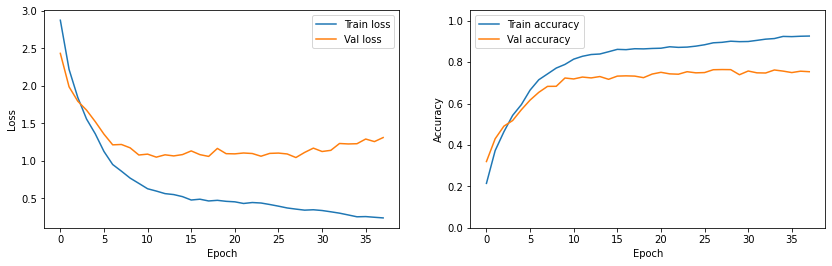

In [41]:
# Plot loss
fig1, ax1 = plt.subplots(1, 2, figsize = (14, 4))
ax1[0].plot(HST3huge.history['loss'], label='Train loss')
ax1[0].plot(HST3huge.history['val_loss'], label='Val loss')
ax1[0].legend()
ax1[0].set_xlabel('Epoch')
ax1[0].set_ylabel('Loss')

# Plot accuracy
ax1[1].plot(HST3huge.history['accuracy'], label='Train accuracy')
ax1[1].plot(HST3huge.history['val_accuracy'], label='Val accuracy')
ax1[1].legend()
ax1[1].set_xlabel('Epoch')
ax1[1].set_ylabel('Accuracy')
ax1[1].set_ylim(0, 1.05)

print()
scores3huge = model_bidirectional.evaluate(X_test3, y_test3, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores3huge[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model_bidirectional,
                                                     batch_size = BATCH_SIZE3)/1e6))

plt.show()

In [ ]:
#saving the model
save_model(model_bidirectional,"model_bidirectional.h5")

## 4. LSTM with GRU

In [42]:
with tpu_strategy.scope():
    #Considering the GRU layer
    model_bidirectional2 = keras.models.Sequential()
    model_bidirectional2.add(keras.Input(shape = (1, 60)))
    model_bidirectional2.add(keras.layers.GRU(256, return_sequences = True))
    model_bidirectional2.add(keras.layers.Bidirectional(keras.layers.LSTM(1024, return_sequences = True)))
    model_bidirectional2.add(keras.layers.Dropout(0.2))
    model_bidirectional2.add(keras.layers.Bidirectional(keras.layers.LSTM(2048, return_sequences = True)))
    model_bidirectional2.add(keras.layers.Dropout(0.2))
    model_bidirectional2.add(keras.layers.GRU(512, return_sequences = False))
    model_bidirectional2.add(keras.layers.Dropout(0.2))  
    model_bidirectional2.add(keras.layers.Flatten())         
    model_bidirectional2.add(keras.layers.Dense(50, activation="softmax"))

    model_bidirectional2.compile(loss = "categorical_crossentropy",
                                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                                 metrics = ["accuracy"])
    
print(model_bidirectional2.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 256)            244224    
                                                                 
 bidirectional_10 (Bidirecti  (None, 1, 2048)          10493952  
 onal)                                                           
                                                                 
 dropout_17 (Dropout)        (None, 1, 2048)           0         
                                                                 
 bidirectional_11 (Bidirecti  (None, 1, 4096)          67125248  
 onal)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 1, 4096)           0         
                                                                 
 gru_1 (GRU)                 (None, 512)              

In [43]:
HST4huge = model_bidirectional2.fit(X_train3, y_train3,
                                    epochs = 200,
                                    batch_size = BATCH_SIZE3,
                                    validation_data = (X_valid3, y_valid3),
                                    verbose = 0,
                                    callbacks = [keras.callbacks.EarlyStopping(monitor = "val_accuracy",
                                                                               patience = 10)])


125/125 - 2s - loss: 1.3183 - accuracy: 0.7438 - 2s/epoch - 14ms/step
Accuracy on test: 74.38%
Memory used: 90.6 Mb


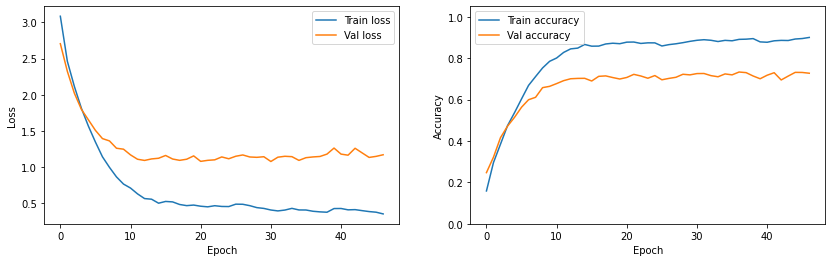

In [46]:
# Plot loss
fig1, ax1 = plt.subplots(1, 2, figsize = (14, 4))
ax1[0].plot(HST4huge.history['loss'], label='Train loss')
ax1[0].plot(HST4huge.history['val_loss'], label='Val loss')
ax1[0].legend()
ax1[0].set_xlabel('Epoch')
ax1[0].set_ylabel('Loss')

# Plot accuracy
ax1[1].plot(HST4huge.history['accuracy'], label='Train accuracy')
ax1[1].plot(HST4huge.history['val_accuracy'], label='Val accuracy')
ax1[1].legend()
ax1[1].set_xlabel('Epoch')
ax1[1].set_ylabel('Accuracy')
ax1[1].set_ylim(0, 1.05)

print()
scores4 = model_bidirectional.evaluate(X_test3, y_test3, verbose = 2)
print("="*71)
print("Accuracy on test: {:.2f}%".format(scores4[1]*100))
print("Memory used: {:.1f} Mb".format(
        evaluation.keras_model_memory_usage_in_bytes(model = model_bidirectional2,
                                                     batch_size = BATCH_SIZE3)/1e6))

plt.show()